In [38]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [39]:
pip install yahooquery

Note: you may need to restart the kernel to use updated packages.


In [40]:
# Raw Package
import numpy as np
import pandas as pd

#Data Source
import yfinance as yf

#Data viz
import plotly.graph_objs as go

from re import search
from yahooquery import Screener

In [41]:
def getRates(ticker_input ,period_input  ,interval_input ):
    print(ticker_input+" "+period_input+" "+interval_input )
    data = yf.download(tickers=ticker_input, period = period_input, interval = interval_input)
    return data["Close"]

In [42]:
def getPercChange(d):
    x=round(d.head(1),6).values
    y=round(d.tail(1),6).values
    perc_chg= np.round( (  (y-x) / abs(x)  ) *100  , 4)
    return perc_chg

In [43]:
def mail2me(pair_text,message_text):
    from email.message import EmailMessage
    import smtplib
    from pretty_html_table import build_table

    sender = "ozukun83@gmail.com"
    recipient = "ozukun83@gmail.com"
    message = "Crypto Info all"

    password = input("Type your password and press enter: ")
    
    email = EmailMessage()
    email["From"] = sender
    email["To"] = recipient
    email["Subject"] = "Crypto Rates Python!"+"  "+pair_text
    email.set_content(message_text)

    
    
    smtp = smtplib.SMTP_SSL("smtp.gmail.com")
    smtp.login(sender, password)
    smtp.sendmail(sender, recipient, email.as_string())
    smtp.quit()
    print("Mail succeed !!")

In [44]:
# get all crypto pairs with USD
def getCryptoPairs():
    s = Screener()
    tickers=[]
    data = s.get_screeners('all_cryptocurrencies_us', count=250)

    # data is in the quotes key
    dicts = data['all_cryptocurrencies_us']['quotes']
    symbols = [d['symbol'] for d in dicts]
    symbols[0]

    for s in symbols:
        if  search("USD", s) and not search("USDT", s) and not search("USDC", s): #\
        #and ( search("ETH",s) or search("DOGE",s) ):
            #print(s+"\n")
            tickers.append(s)
             
    return tickers
        

#for cp in getCryptoPairs():
#    print(cp)

In [45]:
# moving average
def get_ma(prices, rate):
    return prices.rolling(rate).mean()



def get_bollinger_bands(prices, rate=7):
    sma = get_ma(prices, rate)
    std = prices.rolling(rate).std()
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return bollinger_up, bollinger_down


def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    
    macd = pd.DataFrame(exp1 - exp2)
    macd.columns=["macd"]
    
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean())
    signal.columns=["signal"]
    
    hist = pd.DataFrame(macd['macd'] - signal['signal'])
    hist.columns=["hist"]
    
    
    
    frames =  [macd, signal, hist]
    
    
    
    df = pd.concat(frames, join = 'inner', axis = 1)
    df["result"]= np.select([df.macd > df.signal , df.macd < df.signal], ["Buy", "Sell"])
    return df




#HISTOGRAM = MACD LINE - SIGNAL LINE

#IF MACD LINE > SIGNAL LINE => BUY THE STOCK
#IF SIGNAL LINE > MACD LINE => SELL THE STOCK

#---------------------------------------------------------------


df_tmp_f = pd.DataFrame()
df_buy_signal=pd.DataFrame()
final_text=""
#Crypto_Pairs=["BTC-USD","ETH-USD","ALGO-USD","SOL-USD","LUNC-USD","ROSE-USD","SHIB-USD","XRP-USD","ADA-USD"]

Crypto_Pairs=[]
for cpx in getCryptoPairs():
    Crypto_Pairs.append(cpx)

for cp in Crypto_Pairs:

    df_tmp_0 = pd.DataFrame(getRates(cp,  '1y',  '1d'))

    bollinger_up, bollinger_down = get_bollinger_bands(df_tmp_0)

    cp_macd=get_macd(getRates(cp,  '1y',  '1d'), 26, 12, 9)
    
    #display(cp_macd.iloc[-7:])

    df_tmp = pd.DataFrame(data=np.column_stack((df_tmp_0.values,bollinger_up,bollinger_down,cp_macd.macd,
                                                cp_macd.signal,cp_macd.result )),
                          columns=['Price','Bol_Up','Bol_Down',"macd","signal","result"])
    df_tmp.insert(0,'Crypto_Pair',cp)
    df_tmp.index=df_tmp_0.index


    #display( df_tmp.iloc[-7:] )
    
    x=round( df_tmp["Bol_Up"].iloc[-90:].mean() ,6 )
    #print("Bol_Up__Mean_for_last_7days   : " + str( x ) )
    
    
    y=round( df_tmp["Bol_Down"].iloc[-90:].mean() ,6 )
    #print("Bol_Down__Mean_for_last_7days : " + str( y ) )
    
    
    df_tmp_2 = pd.DataFrame(data=np.column_stack((cp,df_tmp.iloc[-1].Price,x,y )),
                          columns=["Crypto_Pair",'Price','Bol_Up_30','Bol_Down_30'])
    
    
    #display( df_tmp_2["Bol_Up_30"].values )
    
    x1="Bol_Up__Mean_for_last_7days   : " + str( x )
    y1="Bol_Down__Mean_for_last_7days : " + str( y )
    
    df_tmp_f = df_tmp_f.append(df_tmp.iloc[-7:])
    final_text=final_text+"\n"+cp+"\n"+str(x1)+"\n"+str(y1)
    
    if df_tmp.iloc[-1].Price+(df_tmp.iloc[-1].Price*0.2)<float(df_tmp_2["Bol_Up_30"].values) :
        print("BUY_signal")
        df_buy_signal=df_buy_signal.append(df_tmp_2)
        #display(df_buy_signal)
        
#---------------------------------------------------------------------------
display(df_buy_signal)
#mail2me_v2(df_buy_signal,"Crypto Bollinger bands",final_text)
#mail2me_v2(df_buy_signal,"Crypto Bollinger bands","")

BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BNB-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BNB-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
XRP-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
XRP-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BUSD-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BUSD-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
ADA-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
DO

,Crypto_Pair,Price,Bol_Up_30,Bol_Down_30
0,HEX-USD,0.026615722104907036,0.032998,0.026109
0,CHZ-USD,0.13939610123634338,0.190007,0.142693
0,HT-USD,5.106838226318359,7.042468,5.659594
0,FTT-USD,2.2030351161956787,9.16088,5.622505
0,BTT-USD,7.267502155627881e-07,1e-06,1e-06
0,OSMO-USD,0.8578560948371887,1.134825,0.928815
0,ETHW-USD,3.8282387256622314,4.782271,3.800334
0,KAVA-USD,0.8524308204650879,1.072447,0.875991
0,MV-USD,0.1553657203912735,0.216277,0.174691
0,XCN18679-USD,0.012240178883075714,0.042911,0.032648


In [46]:
# get all crypto pairs with USD
def getCryptoPairs():
    s = Screener()
    tickers=[]
    data = s.get_screeners('all_cryptocurrencies_us', count=100)

    # data is in the quotes key
    dicts = data['all_cryptocurrencies_us']['quotes']
    symbols = [d['symbol'] for d in dicts]
    symbols[0]

    for s in symbols:
        if  search("USD", s) and not search("USDT", s) and not search("USDC", s): #\
        #and ( search("ETH",s) or search("DOGE",s) ):
            #print(s+"\n")
            tickers.append(s)
             
    return tickers
        

#for cp in getCryptoPairs():
#    print(cp)

In [47]:
def getRatesTable(*args):
    df_table = pd.DataFrame()
    for cp in args:
        df10yr=getRates(cp, '10y',  '1d')
        df5yr=getRates(cp,  '5y',  '1d')
        df3yr=getRates(cp,  '3y',  '1d')
        df1yr=getRates(cp,  '1y',  '1d')
        df3mo=getRates(cp,  '3mo',  '1h')
        df1mo=getRates(cp,  '1mo',  '1h')
        df1wk=getRates(cp,  '1wk',  '1h')
        df1dy=getRates(cp,  '1dy',  '1h')
        new_row = pd.Series(data={
                                   'Crypto_Pair':cp,
                                   '10yr_d_CHG%':getPercChange(df10yr)[0],
                                   '5yr_d_CHG%':getPercChange(df5yr)[0],
                                   '3yr_d_CHG%':getPercChange(df3yr)[0],
                                   '1yr_d_CHG%':getPercChange(df1yr)[0], 
                                   '3mo_h_CHG%':getPercChange(df3mo)[0], 
                                   '1mo_h_CHG%':getPercChange(df1mo)[0] ,
                                   '1wk_h_CHG%':getPercChange(df1wk)[0],
                                   '1dy_h_CHG%':getPercChange(df1dy)[0], 
                                 } 
                           )
        
        df_table = df_table.append(new_row, ignore_index=True)
    return df_table

#--------------------------------------------------------------------


#Crypto_Pairs=["BTC-USD","ETH-USD","ALGO-USD","SOL-USD","LUNC-USD","ROSE-USD","SHIB-USD","XRP-USD","ADA-USD"]

Crypto_Pairs=[]
for cp in getCryptoPairs():
    Crypto_Pairs.append(cp)

dfx=getRatesTable(*Crypto_Pairs)

#dfx

BTC-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
BTC-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1mo 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed
BTC-USD 1dy 1h
[*********************100%***********************]  1 of 1 completed
ETH-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
ETH-USD 1y 1d
[*********************100%***********************]  1 of 1 complete

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in true_divide



[*********************100%***********************]  1 of 1 completed
TRX-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
TRX-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
TRX-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
TRX-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed
TRX-USD 1mo 1h
[*********************100%***********************]  1 of 1 completed
TRX-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed
TRX-USD 1dy 1h
[*********************100%***********************]  1 of 1 completed
STETH-USD 10y 1d
[*********************100%***********************]  1 of 1 completed
STETH-USD 5y 1d
[*********************100%***********************]  1 of 1 completed
STETH-USD 3y 1d
[*********************100%***********************]  1 of 1 completed
STETH-USD 1y 1d
[*********************100%***********************]  1 of 1 completed
STETH

In [48]:
display(df_buy_signal)

,Crypto_Pair,Price,Bol_Up_30,Bol_Down_30
0,HEX-USD,0.026615722104907036,0.032998,0.026109
0,CHZ-USD,0.13939610123634338,0.190007,0.142693
0,HT-USD,5.106838226318359,7.042468,5.659594
0,FTT-USD,2.2030351161956787,9.16088,5.622505
0,BTT-USD,7.267502155627881e-07,1e-06,1e-06
0,OSMO-USD,0.8578560948371887,1.134825,0.928815
0,ETHW-USD,3.8282387256622314,4.782271,3.800334
0,KAVA-USD,0.8524308204650879,1.072447,0.875991
0,MV-USD,0.1553657203912735,0.216277,0.174691
0,XCN18679-USD,0.012240178883075714,0.042911,0.032648


In [49]:
def mail2me_v2(df,mail_subject,message_text):
    
    from email.mime.text import MIMEText
    from email.mime.application import MIMEApplication
    from email.mime.multipart import MIMEMultipart
    from smtplib import SMTP
    import smtplib
    import sys


    recipients = ['ozukun83@gmail.com'] 
    emaillist = [elem.strip().split(',') for elem in recipients]
    msg = MIMEMultipart()
    msg['Subject'] = mail_subject
    msg['From'] = 'ozukun83@gmail.com'

    password = input("Type your password and press enter: ")
    

    html = """\
    <html>
      <head></head>
      <body>
        {0}
      </body>
    </html>
    """.format(df.to_html())

    part1 = MIMEText(html, 'html')
    msg.attach(part1)
    body = message_text
    body = MIMEText(body) # convert the body to a MIME compatible string
    msg.attach(body)

    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.ehlo()
    server.starttls()
    server.ehlo()
    server.login("ozukun83@gmail.com",password)
    server.sendmail(msg['From'], emaillist , msg.as_string())
    print("Mail succeed !!")
    
#---------------------------------------------------------------------------
#mail2me_v2(dfx,"Crypto Rate changes","")

ETH-USD 1wk 1h
[*********************100%***********************]  1 of 1 completed


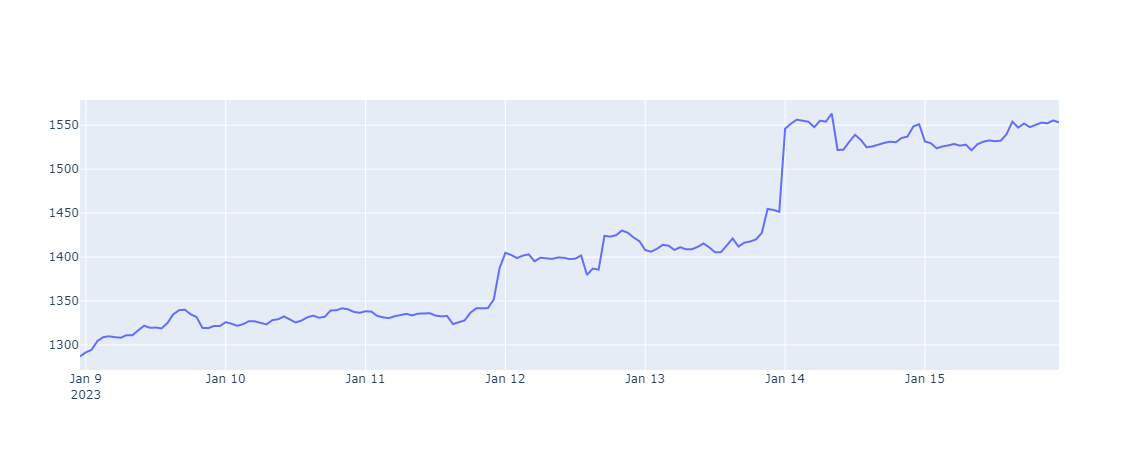

ETH-USD 3mo 1h
[*********************100%***********************]  1 of 1 completed


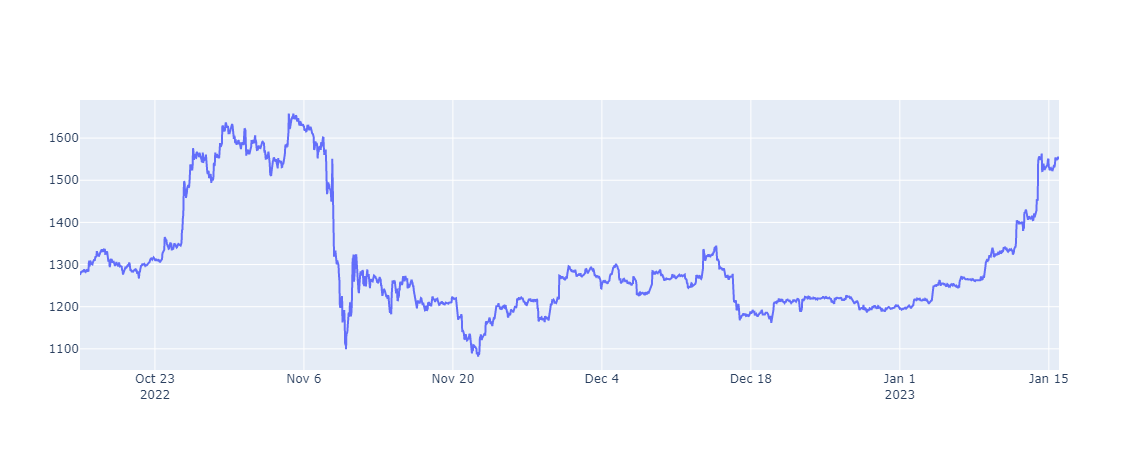

In [50]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

def getLine(df_input):
    x = df_input.index
    y = df_input.values
    fig = go.Figure(data=go.Scatter(x = x, y = y))
    fig.show()
    
#------------------------------------------------

#( getLine(getRates('ETH-USD',  '1d',  '1h')) )
( getLine(getRates('ETH-USD',  '1wk',  '1h')) )
( getLine(getRates('ETH-USD',  '3mo',  '1h')) )
#( getLine(getRates('ETH-USD',  '3y',  '1d')) )

In [51]:

html = dfx.to_html()
# Write the HTML to a file
with open('crypto_change.html', 'w') as f:
  f.write(html)

# Display the HTML in a web browser
from IPython.display import display, HTML
display(HTML(html))

,Crypto_Pair,10yr_d_CHG%,5yr_d_CHG%,3yr_d_CHG%,1yr_d_CHG%,3mo_h_CHG%,1mo_h_CHG%,1wk_h_CHG%,1dy_h_CHG%
0,BTC-USD,4467.8855,51.1635,137.2030,-51.6171,9.5703,20.3297,22.2686,0.4692
1,ETH-USD,384.3120,20.2923,834.8935,-53.3384,21.8749,22.7654,20.7569,1.4773
2,BNB-USD,15078.9513,1444.5063,1611.5901,-38.9525,12.5600,17.1436,10.1734,-0.3058
3,XRP-USD,77.0852,-77.0304,65.3702,-50.7131,-20.0090,1.8606,11.4655,-1.3114
4,BUSD-USD,-0.1379,-0.1379,-0.0039,0.1002,0.0056,0.0225,-0.0973,0.0322
5,ADA-USD,992.5966,-55.0198,722.9972,-72.9831,-3.6842,16.7546,18.8962,0.4990
6,DOGE-USD,5979.2933,772.6996,3531.1524,-53.5275,46.8428,1.6484,16.8587,0.4942
7,MATIC-USD,22211.7847,22211.7847,5926.4174,-58.0912,24.8109,12.4501,17.3152,0.4578
8,SOL-USD,2321.0298,2321.0298,2321.0298,-84.4214,-22.1699,64.3890,60.6425,-2.4243
9,DOT-USD,105.2094,105.2094,105.2094,-78.5439,-1.6932,13.9118,23.9080,0.1475


In [52]:
html = df_tmp_f.to_html()
# Write the HTML to a file
with open('crypto_bol.html', 'w') as f:
  f.write(html)

# Display the HTML in a web browser
from IPython.display import display, HTML
display(HTML(html))

,Crypto_Pair,Price,Bol_Up,Bol_Down,macd,signal,result
Date,,,,,,,
2023-01-09 00:00:00+00:00,BTC-USD,17196.554688,17279.089426,16599.361467,13.207424,-56.912671,Buy
2023-01-10 00:00:00+00:00,BTC-USD,17446.292969,17480.139736,16617.292741,55.648513,-34.400435,Buy
2023-01-11 00:00:00+00:00,BTC-USD,17934.896484,17961.651582,16441.968954,127.242826,-2.071782,Buy
2023-01-12 00:00:00+00:00,BTC-USD,18869.587891,18888.375787,16096.059481,256.447454,49.632065,Buy
2023-01-13 00:00:00+00:00,BTC-USD,19909.574219,20109.574762,15719.890639,437.715545,127.248761,Buy
2023-01-14 00:00:00+00:00,BTC-USD,20976.298828,21474.514326,15503.871276,659.841334,233.767275,Buy
2023-01-15 00:00:00+00:00,BTC-USD,20899.78125,22211.582028,15854.985495,820.247984,351.063417,Buy
2023-01-09 00:00:00+00:00,ETH-USD,1321.53894,1332.205954,1200.448866,13.161297,0.320901,Buy
2023-01-10 00:00:00+00:00,ETH-USD,1336.58606,1350.408883,1217.048009,18.692126,3.995146,Buy
